# Vega

In [1]:
import numpy as np
import os
from astropy.io import fits
from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from IPython.display import Image
# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist
from IPython.display import Image
import glob

from PIL import Image
import numpy as np
import pylab as pl
pl.style.use('dark_background')

from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter

In [2]:
vega_30s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\vega_30s003.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_30s00*.FIT")],
                        axis=0)
             )

In [3]:
veg_array = np.array(vega_30s_image_data)
veg_array = veg_array - np.median(vega_30s_image_data)

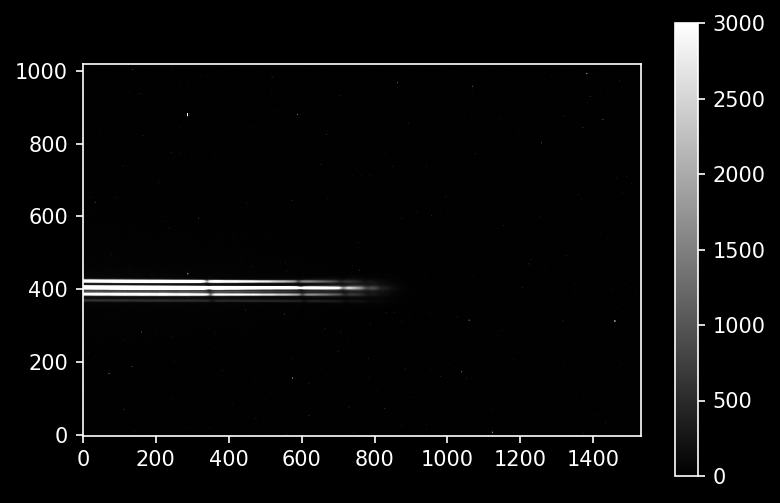

In [4]:
%matplotlib inline
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.dpi'] = 150
pl.matplotlib.style.use('dark_background') # Optional!
pl.imshow(vega_30s_image_data, cmap='gray', vmax=0, vmin=3000)
pl.colorbar()

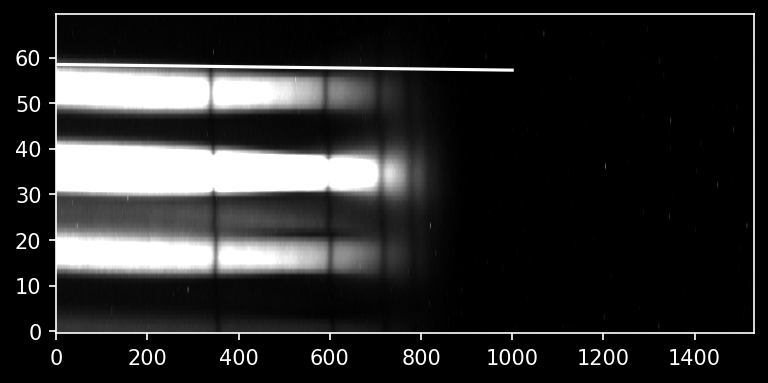

In [5]:
dy = -1
dx = 800
slope = dy/dx

ystart = 370
yend = 440

pl.imshow(veg_array[ystart:yend,:], cmap='gray', vmax=3000, vmin=0)
pl.plot([0,1000], 58.5 + np.array([0,1000]) * slope, color='w')
pl.gca().set_aspect(10)

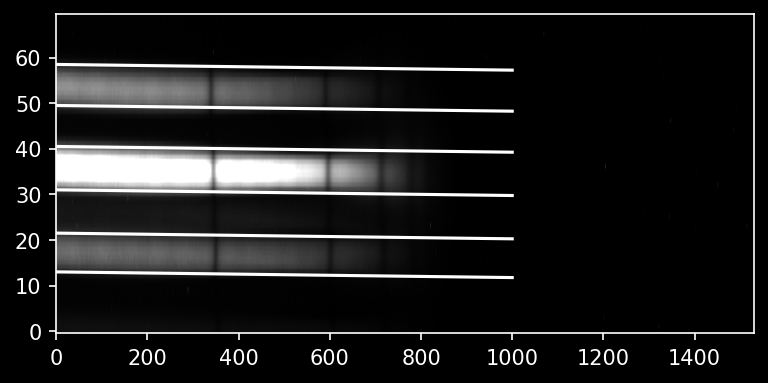

In [6]:
intertrace_cuts = np.array([13, 21.5, 31, 40.5, 49.5, 58.5])
pl.imshow(veg_array[ystart:yend,:], cmap='gray', vmax=10000, vmin=0)
pl.plot([0,1000], intertrace_cuts + np.array([0,1000])[:,None] * slope, color='w')
pl.gca().set_aspect(10)

In [7]:
npixels_to_cut = 4 # very conservative - we'll see why below
xvals = np.arange(veg_array.shape[1])
trace_center = ystart+(intertrace_cuts[2] + intertrace_cuts[3])/2 + xvals * slope
cutout_trace = np.array([veg_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)]).T
cutout_trace.shape

(8, 1530)

In [8]:
npixels_to_cut = 4 # very conservative - we'll see why below
xvals = np.arange(veg_array.shape[1])
trace_center = ystart+(intertrace_cuts[0] + intertrace_cuts[1])/2 + xvals * slope
cutout_trace = np.array([veg_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)]).T

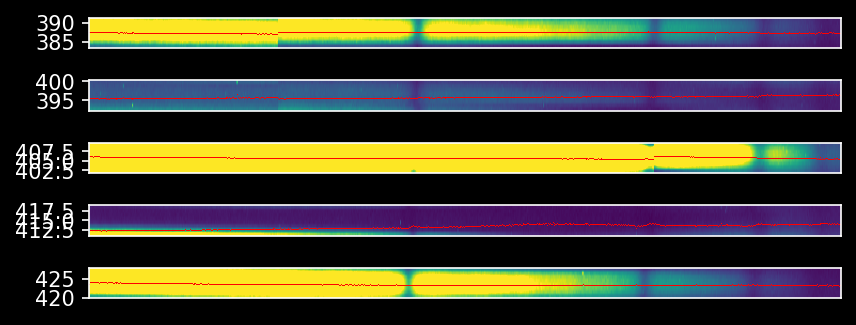

In [9]:
# to get the y-axis values corresponding to each part of our cutout trace, we do the same operation we did on the image
yaxis_full = np.arange(veg_array.shape[0])
yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                    for yval, ii in zip(trace_center, xvals)]).T
xend = 800
weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
pl.figure(figsize=(8,3))
traces = {}
for trace_index in range(len(intertrace_cuts)-1):
    yoffset = ystart + (intertrace_cuts[trace_index] + intertrace_cuts[trace_index+1])/2
    trace_center = yoffset + slope * xvals

    cutout_trace = np.array([veg_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                        for yval, ii in zip(trace_center, xvals)]).T
    yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                     for yval, ii in zip(trace_center, xvals)]).T
    weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
    
    # it takes a little mental gymnastics to get to this, but: to show the trace properly on our cutout,
    # we need to calculate the local version
    local_weighted_yaxis_values = np.average(np.arange(npixels_to_cut*2)[:,None] * np.ones(xend)[None,:],
                                             axis=0, weights=cutout_trace[:,:xend])
    
    traces[trace_index] = weighted_yaxis_values
    ax = pl.subplot(7, 1, trace_index+1)
    ax.imshow(cutout_trace[:,:xend], extent=[0, xend, yoffset-npixels_to_cut, yoffset + npixels_to_cut],vmax=3000, vmin=0 )
    ax.plot(xvals[:xend], yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend], 'r,')
    ax.set_aspect(4)
    ax.set_xticks([])
pl.tight_layout()

(0.0, 800.0, 370.0, 440.0)

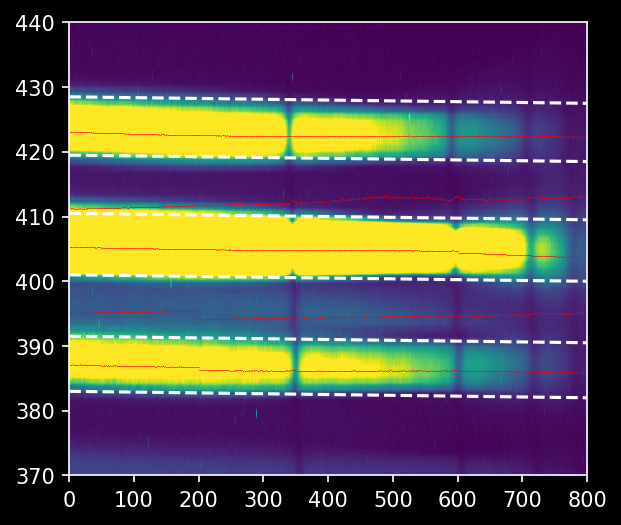

In [10]:
# then we can plot the "global" version here
pl.imshow(veg_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend], vmax=3000, vmin=0)
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for trace in traces.values():
    pl.plot(xvals[:xend], trace[:xend], 'r,', alpha=0.5)
pl.axis((0,xend,ystart,yend))

In [11]:
traces = {key: traces[key] for key in [0,2,4]}

(0.0, 800.0, 370.0, 440.0)

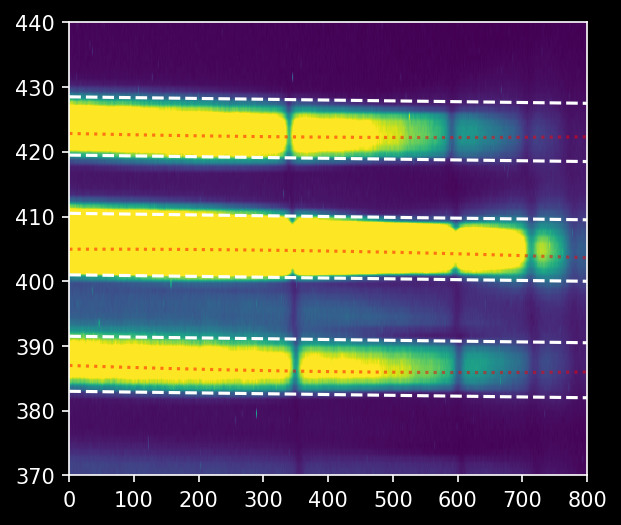

In [12]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

pl.imshow(veg_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=3000,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

(0.0, 800.0)

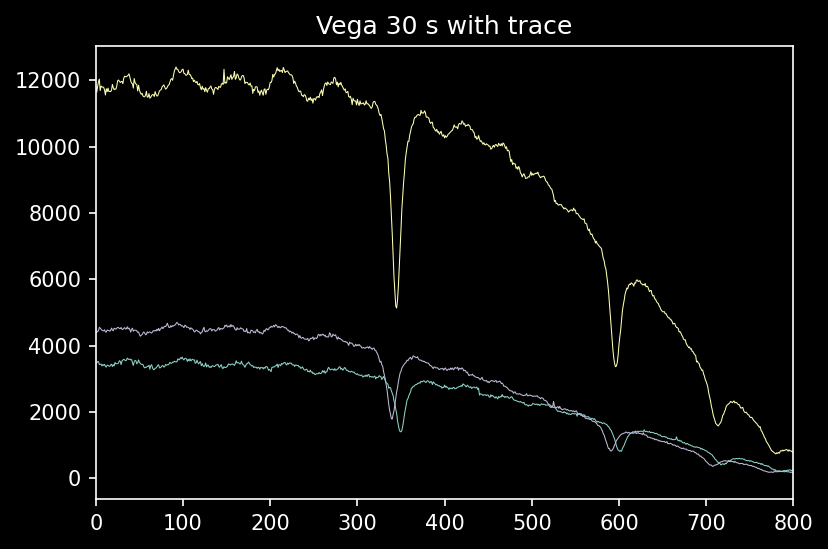

In [13]:
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

npixels_to_cut_trace = 4
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([veg_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            veg_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum
    
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
    pl.title("Vega 30 s with trace")
pl.xlim(0,800)

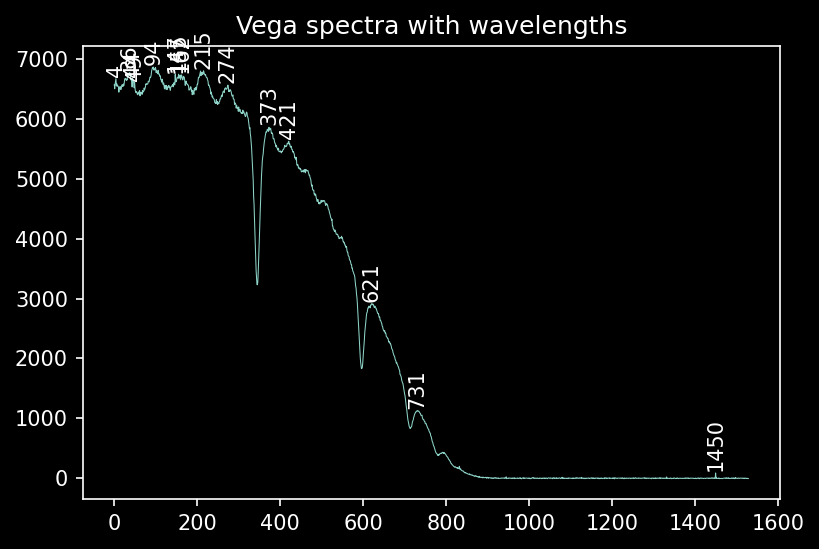

In [14]:
import scipy.signal

mean_veg = np.nanmean([spectra[ind] for ind in spectra], axis = 0)
pl.plot(mean_veg, linewidth = 0.5)
pl.title("Vega spectra with wavelengths")


peaks,_ = scipy.signal.find_peaks(mean_veg, prominence = 80)

for peak in peaks:
    pl.text(peak,
           min([mean_veg[peak] + 100, 7000]), peak,
           rotation = 90, horizontalalignment = 'center',)
    

In [15]:
peaks

array([   4,   36,   44,   49,   94,  147,  155,  162,  215,  274,  373,
        421,  621,  731, 1450], dtype=int64)

# Absorption fit 1

In [16]:
## don't have darks for these so using 30 s - if hot pixles are sensitive then this might be an issue 
he_20s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\he_20s.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_30s00*.FIT")],
                        axis=0)
             )

he_array = np.array(he_20s_image_data)
he_array = he_array - np.median(he_20s_image_data)
xaxis = np.arange(he_20s_image_data.shape[1]) 

In [17]:
# from helium wavelength calibration slope = 1.00238884, intercept=-2.90420708

In [18]:
wlmodel = Linear1D(slope=1.00238884, intercept=-2.90420708)

In [19]:
vega_line = spectra[0]
wavelengths = wlmodel(xaxis) 
wavelengths

array([-2.90420708e+00, -1.90181824e+00, -8.99429400e-01, ...,
        1.52774355e+03,  1.52874594e+03,  1.52974833e+03])

In [20]:
vega_guess = [347,600,718]
npixels = 10
improved_vega_guess = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=vega_line[g-npixels:g+npixels] - np.median(vega_line))
                         for g in vega_guess]
improved_vega_guess

[345.38796830334763, 598.4343381808357, 714.917919649676]

Text(0.5, 0, 'wavelength')

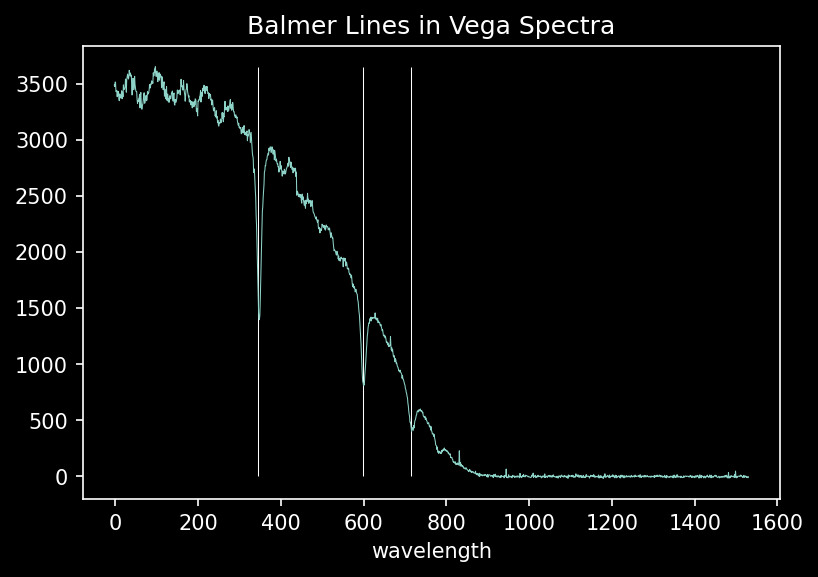

In [21]:
pl.plot(wavelengths, vega_line, linewidth = 0.5)
pl.vlines(x=improved_vega_guess, ymin=0, ymax=max(vega_line), linewidth = 0.5)
pl.title('Balmer Lines in Vega Spectra')
pl.xlabel('wavelength')

Text(0, 0.5, 'Intensity (arbitrary units)')

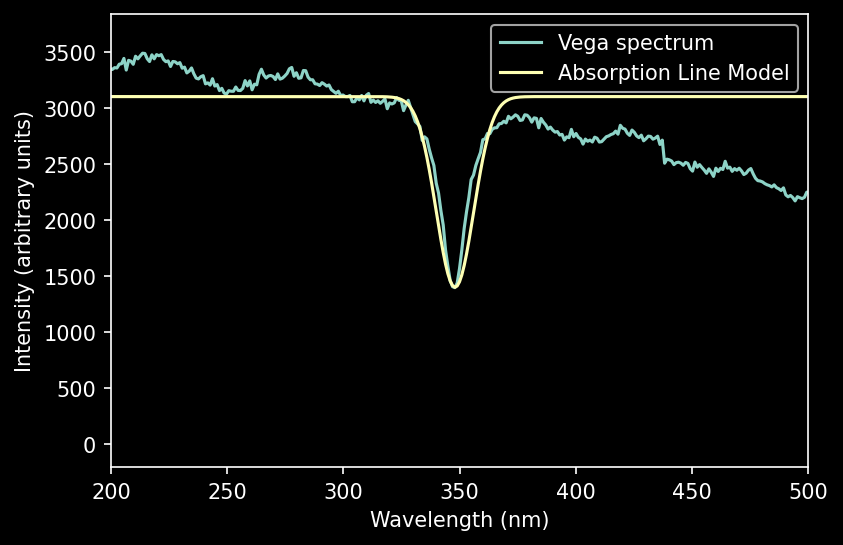

In [23]:
absorption_model_guess = (Linear1D(slope=0, intercept=3100) +
                          Gaussian1D(amplitude=-1700, mean=348, stddev=8))

pl.plot(wavelengths, vega_line, label="Vega spectrum")
pl.plot(wavelengths, absorption_model_guess(wavelengths), label='Absorption Line Model')
pl.xlim([200,500])
pl.legend(loc='best')
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

In [24]:
# fit the absorption line model to the cutout region around the line
lmfitter = LevMarLSQFitter()
selection = (wavelengths > 330) & (wavelengths < 370) 
fitted_absorption_model = lmfitter(model=absorption_model_guess,
                                   x=wavelengths[selection],
                                   y=vega_line[selection])

Text(0, 0.5, 'Intensity (arbitrary units)')

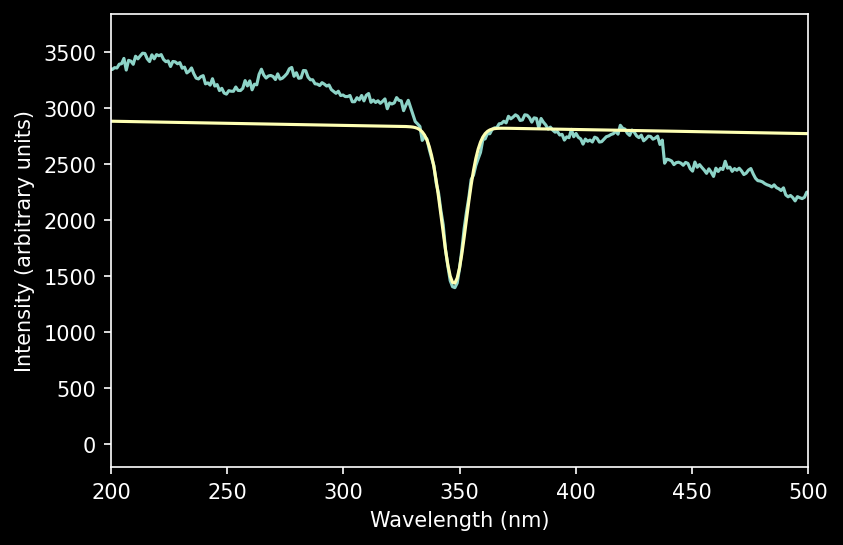

In [25]:
pl.plot(wavelengths, vega_line)
pl.plot(wavelengths, fitted_absorption_model(wavelengths))
pl.xlim([200,500])
#pl.ylim([-100,100])
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

In [26]:
# split our compound model into two components
continuum_fit, absorption_fit = fitted_absorption_model
fitted_absorption_model, continuum_fit, absorption_fit

(<CompoundModel(slope_0=-0.36919702, intercept_0=2954.31422752, amplitude_1=-1392.1837509, mean_1=347.54284292, stddev_1=5.22280204)>,
 <Linear1D(slope=-0.36919702, intercept=2954.31422752)>,
 <Gaussian1D(amplitude=-1392.1837509, mean=347.54284292, stddev=5.22280204)>)

Text(0.5, 1.0, 'Vega Absorption Line Model 1 at ~ 345 nm')

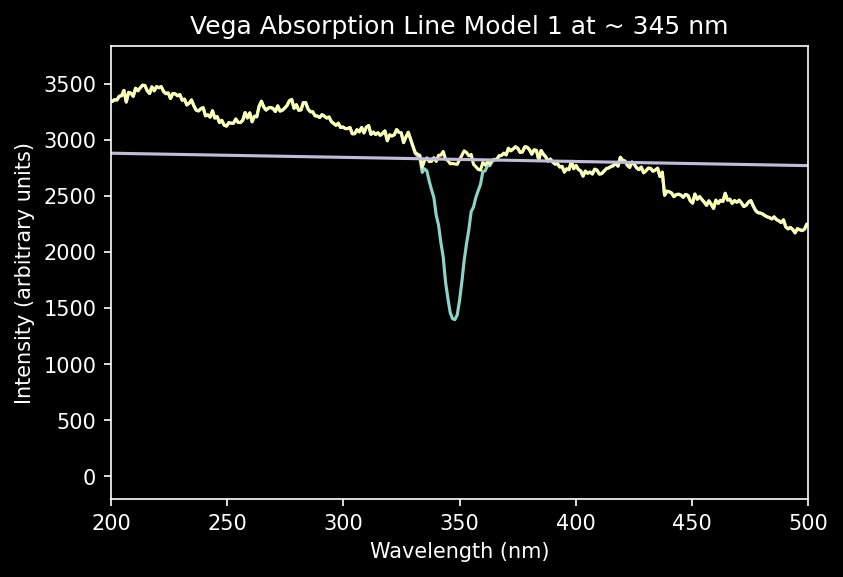

In [27]:
# show the spectrum before and after subtracting the line
pl.plot(wavelengths, vega_line)
pl.plot(wavelengths, vega_line - absorption_fit(wavelengths))
pl.plot(wavelengths, continuum_fit(wavelengths))
pl.xlim([200,500])
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")
pl.title("Vega Absorption Line Model 1 at ~ 345 nm")

Text(0.5, 1.0, 'Vega Absorption Line Model 1 at ~ 345 nm')

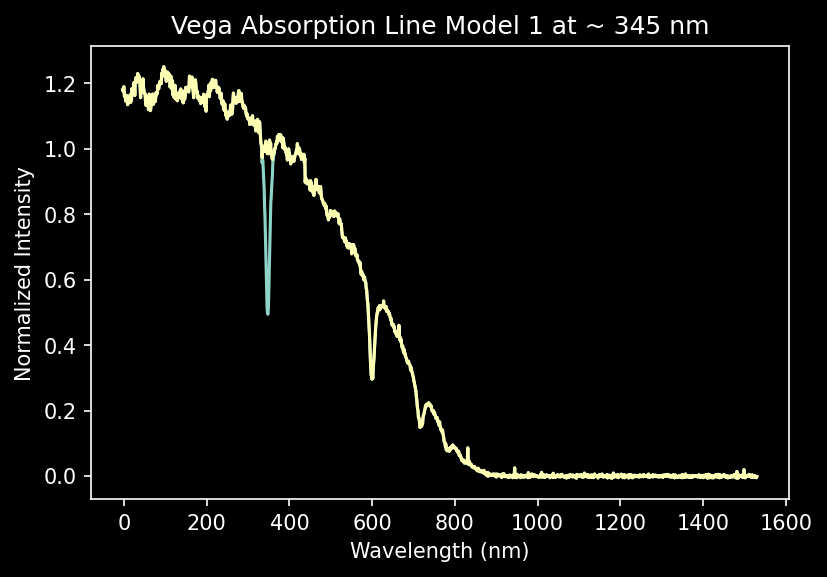

In [28]:
# show the spectrum normalized by the continuum
pl.plot(wavelengths, vega_line / continuum_fit(wavelengths))
residual_normalized = (vega_line - absorption_fit(wavelengths)) / continuum_fit(wavelengths)
pl.plot(wavelengths, residual_normalized)
pl.xlabel("Wavelength (nm)")
pl.ylabel("Normalized Intensity")
pl.title("Vega Absorption Line Model 1 at ~ 345 nm")

# Equivalent Width

In [29]:
EQW1 =  (-absorption_fit(wavelengths[selection]).sum() /
        continuum_fit(wavelengths[selection]).mean()) * u.nm
EQW1

<Quantity 6.4331702 nm>

In [31]:
per_pixel_normalized_uncertainty1 = residual_normalized[selection].std()
eqw_error1 = (per_pixel_normalized_uncertainty**2).sum()**0.5 * u.nm
print(f"EQW = {EQW1:0.3f} +/- {eqw_error:0.3f}")

EQW = 6.433 nm +/- 0.016 nm


In [32]:
# we can also look at the wavelength and width of the absorption line:
absorption_fit

<Gaussian1D(amplitude=-1392.1837509, mean=347.54284292, stddev=5.22280204)>

In [33]:
air_wavelength_hbeta = 486.135*u.nm # wikipedia https://en.wikipedia.org/wiki/Balmer_series

In [34]:
from astropy import constants

doppler_velocity = (absorption_fit.mean*u.nm -
                    air_wavelength_hbeta) / (air_wavelength_hbeta) * constants.c
doppler_velocity.to(u.km/u.s)

<Quantity -85467.7886372 km / s>

In [35]:
# what's the linewidth?
linewidth_kms = (absorption_fit.stddev*u.nm) / air_wavelength_hbeta * constants.c.to(u.km/u.s)
linewidth_kms

<Quantity 3220.82685137 km / s>

In [36]:
fitted_absorption_model

<CompoundModel(slope_0=-0.36919702, intercept_0=2954.31422752, amplitude_1=-1392.1837509, mean_1=347.54284292, stddev_1=5.22280204)>

In [37]:
(slope_variance, intercept_variance,
 amplitude_variance, centroid_variance,
 width_variance) = lmfitter.fit_info['param_cov'].diagonal()

In [38]:
velocity_centroid_error = ((centroid_variance**0.5) / absorption_fit.mean * constants.c).to(u.km/u.s)
print(f"Centroid velocity = {doppler_velocity:0.0f} +/- {velocity_centroid_error:0.0f}")

Centroid velocity = -85467789 m / s +/- 79 km / s


# Absorption fit 2

Text(0, 0.5, 'Intensity (arbitrary units)')

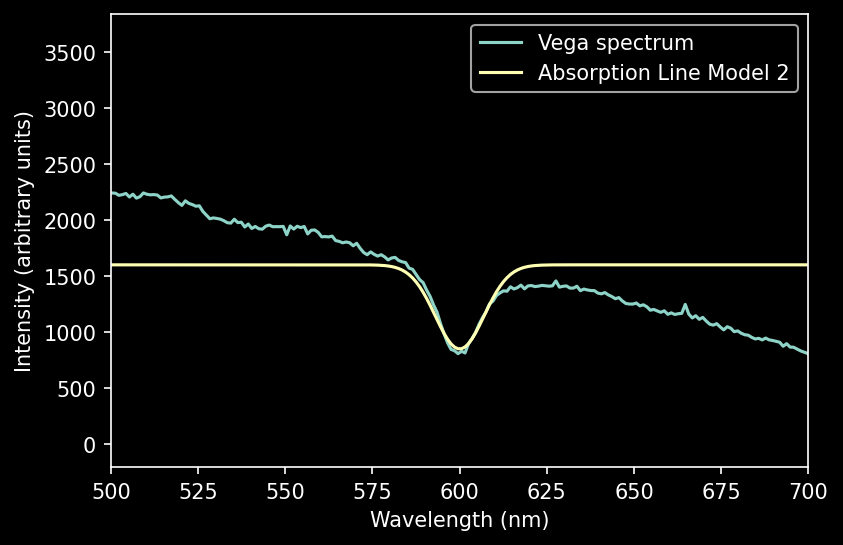

In [39]:
absorption_model_guess2 = (Linear1D(slope=0, intercept=1600) +
                          Gaussian1D(amplitude=-750, mean=600, stddev=7))

pl.plot(wavelengths, vega_line, label="Vega spectrum")
pl.plot(wavelengths, absorption_model_guess2(wavelengths), label='Absorption Line Model 2')
pl.xlim([500,700])
pl.legend(loc='best')
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

Text(0, 0.5, 'Intensity (arbitrary units)')

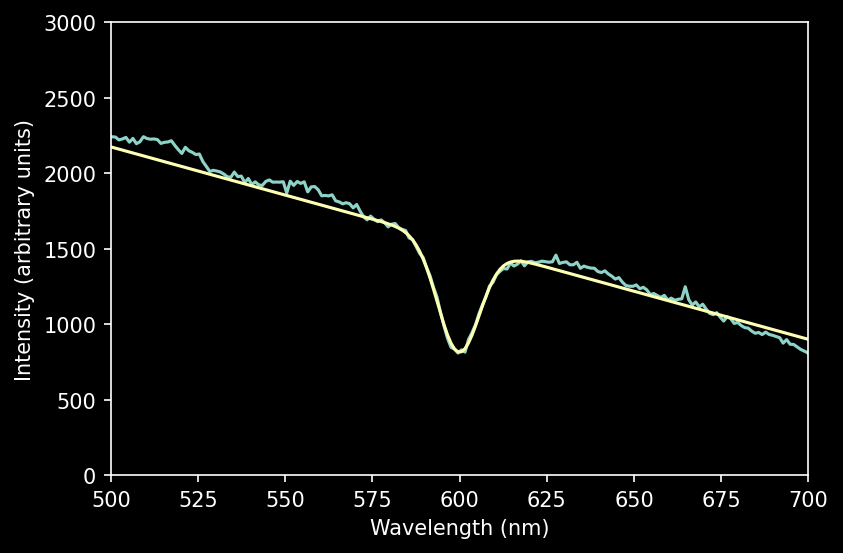

In [40]:
# fit the absorption line model to the cutout region around the line
lmfitter = LevMarLSQFitter()
selection2 = (wavelengths > 575) & (wavelengths < 625) 
fitted_absorption_model2 = lmfitter(model=absorption_model_guess2,
                                   x=wavelengths[selection2],
                                   y=vega_line[selection2])

pl.plot(wavelengths, vega_line)
pl.plot(wavelengths, fitted_absorption_model2(wavelengths))
pl.xlim([500,700])
pl.ylim(0, 3000)
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

In [41]:
# split our compound model into two components
continuum_fit2, absorption_fit2 = fitted_absorption_model2
fitted_absorption_model2, continuum_fit2, absorption_fit2

(<CompoundModel(slope_0=-6.37199851, intercept_0=5359.30313408, amplitude_1=-723.61193484, mean_1=599.66481256, stddev_1=5.97957187)>,
 <Linear1D(slope=-6.37199851, intercept=5359.30313408)>,
 <Gaussian1D(amplitude=-723.61193484, mean=599.66481256, stddev=5.97957187)>)

Text(0.5, 1.0, 'Vega Absorption Line Model 2 at ~ 598 nm')

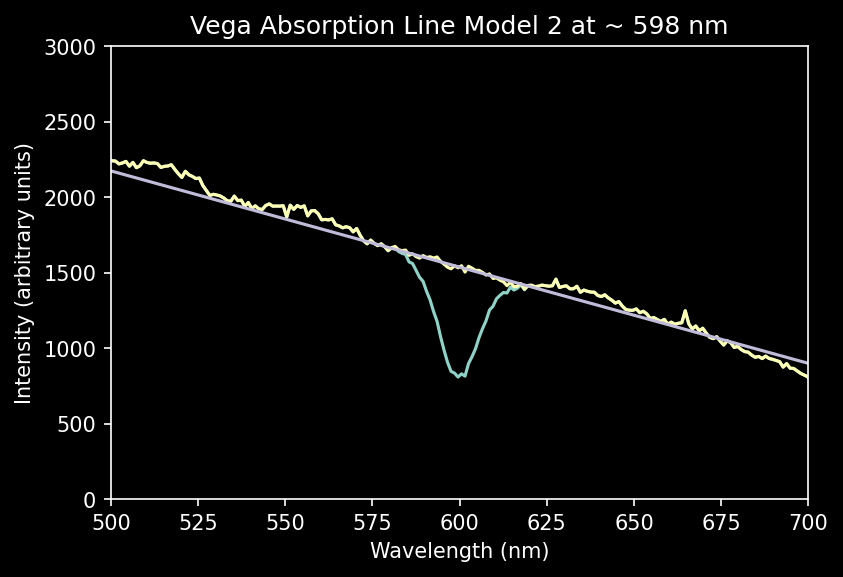

In [42]:
# show the spectrum before and after subtracting the line
pl.plot(wavelengths, vega_line)
pl.plot(wavelengths, vega_line - absorption_fit2(wavelengths))
pl.plot(wavelengths, continuum_fit2(wavelengths))
pl.xlim([500,700])
pl.ylim(0, 3000)
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")
pl.title("Vega Absorption Line Model 2 at ~ 598 nm")

In [43]:
EQW2 =  (-absorption_fit2(wavelengths[selection2]).sum() /
        continuum_fit2(wavelengths[selection2]).mean()) * u.nm
EQW2

<Quantity 7.04458715 nm>

In [44]:
# what's the linewidth?
linewidth_kms2 = (absorption_fit2.stddev*u.nm) / air_wavelength_hbeta * constants.c.to(u.km/u.s)
linewidth_kms2

<Quantity 3687.51591629 km / s>

# Absorption fit 3

Text(0, 0.5, 'Intensity (arbitrary units)')

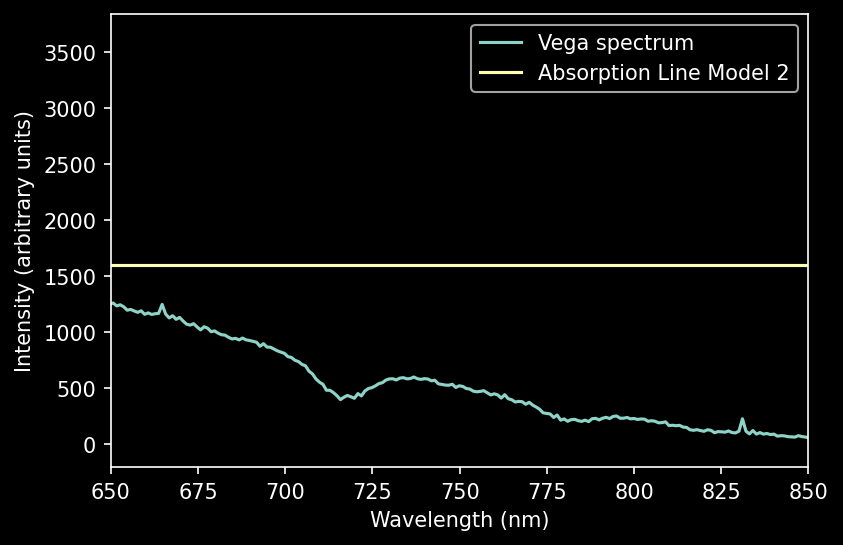

In [45]:
absorption_model_guess3 = (Linear1D(slope=0, intercept=700) +
                          Gaussian1D(amplitude=-250, mean=718, stddev=8))

pl.plot(wavelengths, vega_line, label="Vega spectrum")
pl.plot(wavelengths, absorption_model_guess2(wavelengths), label='Absorption Line Model 2')
pl.xlim([650,850])
pl.legend(loc='best')
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

Text(0, 0.5, 'Intensity (arbitrary units)')

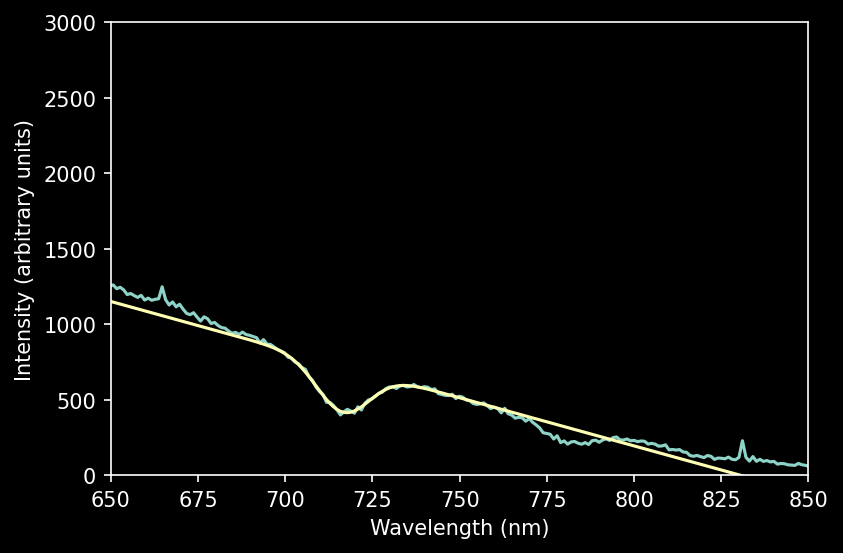

In [46]:
# fit the absorption line model to the cutout region around the line
lmfitter = LevMarLSQFitter()
selection3 = (wavelengths > 700) & (wavelengths < 750) 
fitted_absorption_model3 = lmfitter(model=absorption_model_guess3,
                                   x=wavelengths[selection3],
                                   y=vega_line[selection3])

pl.plot(wavelengths, vega_line)
pl.plot(wavelengths, fitted_absorption_model3(wavelengths))
pl.xlim([650,850])
pl.ylim(0, 3000)
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

In [47]:
# split our compound model into two components
continuum_fit3, absorption_fit3 = fitted_absorption_model3
fitted_absorption_model3, continuum_fit3, absorption_fit3

(<CompoundModel(slope_0=-6.37545622, intercept_0=5293.65490784, amplitude_1=-308.90536052, mean_1=716.4653226, stddev_1=7.51798016)>,
 <Linear1D(slope=-6.37545622, intercept=5293.65490784)>,
 <Gaussian1D(amplitude=-308.90536052, mean=716.4653226, stddev=7.51798016)>)

Text(0.5, 1.0, 'Vega Absorption Line Model 2 at ~ 714 nm')

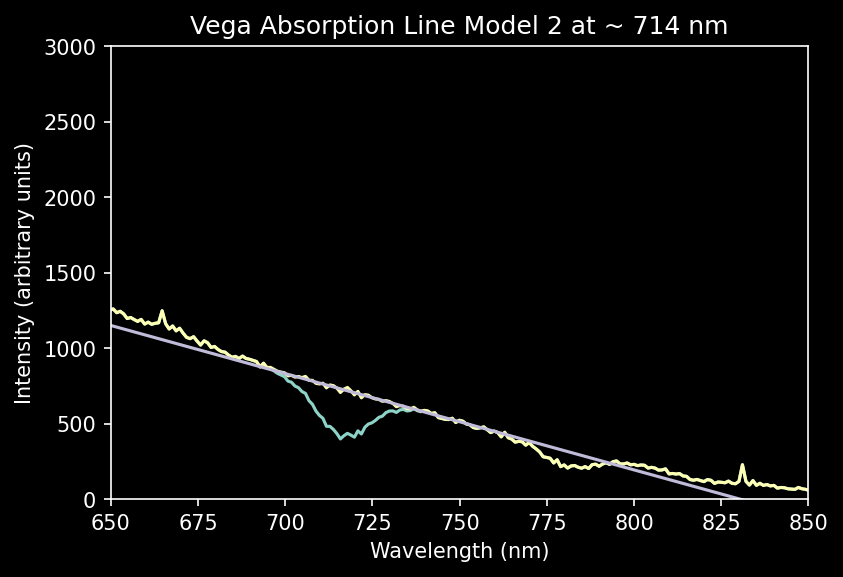

In [48]:
# show the spectrum before and after subtracting the line
pl.plot(wavelengths, vega_line)
pl.plot(wavelengths, vega_line - absorption_fit3(wavelengths))
pl.plot(wavelengths, continuum_fit3(wavelengths))
pl.xlim([650,850])
pl.ylim(0, 3000)
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")
pl.title("Vega Absorption Line Model 2 at ~ 714 nm")

In [49]:
EQW3 =  (-absorption_fit3(wavelengths[selection3]).sum() /
        continuum_fit3(wavelengths[selection3]).mean()) * u.nm
EQW3

<Quantity 8.54130953 nm>

In [50]:
# what's the linewidth?
linewidth_kms3 = (absorption_fit3.stddev*u.nm) / air_wavelength_hbeta * constants.c.to(u.km/u.s)
linewidth_kms3

<Quantity 4636.23016583 km / s>